# 时间序列概述

本代码来自弗朗西斯卡所著《时间序列预测：基于机器学习和python实现》

In [5]:
import scipy
import numpy as np
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import datetime as dt
import warnings
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy import stats
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import math
import os
import shutil
from collections import UserDict
from glob import glob
from IPython.display import Image
from datetime import datetime

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

## 时间序列的特性

时间序列通常包含与事件相关的特定信息和特征：
- **趋势**：此特征描述了长时间（而非季节性或周期性）的时间序列相对于较高或较低值的可见变化。
* **季节性**：此特征描述了**固定时间段内**时间序列中的重复性和持久性模式。
- **周期性**：此特征描述了时间序列数据中向上和向下变化的重复性和持续性模式，但**没有显示固定**的模式。
* **噪声**：此特征描述了时间序列中数据的不规则值，因为没有重复性和持久性的模式。

### 趋势性

时间序列分析主要有三个组成部分：**长期运动或趋势**、**短期运动**（季节性短期运动、周期性短期运动）和**随机或不规则波动**。
- 长期运动或趋势是指时间序列在一个较长的时间间隔内整体增加或减少的运动。
* 短期运动：
  - 季节性变化是显示相同变化的周期性时间波动，通常在不到一年的时间内重复出现。季节性总是有固定且已知的时期。如节日、天气和气候条件等。
  - 周期性变化是一种周期性的模式，存在于数据显示上升和下降时，而不是固定的时期。一个完整的时期是一个周期，但一个周期不会有特定的预定时间长度，即使这些时间波动的持续时间通常超过一年。如商业周期等。
- 随机或不规则波动是最后一个引起时间序列数据变化的因素。这些波动是不可控制的、不可预测的、不稳定的。如地震、战争等。

一边情况下，将**长期运动或趋势**、**短期运动**（季节性短期运动、周期性短期运动）作为时间序列数据中的信号，**随机或不规则波动**作为噪声。

### 平稳性

**平稳性**：平稳性是指时间序列的统计参数不会随时间变化。即均值和方差，不随时间变化。
- 强平稳：时间序列的所有统计参数不随时间变化。
* 弱平稳：时间序列的均值和自协方差函数不随时间变化。

判断时间序列数据是否为平稳时间序列或非平稳时间序列，通常可以通过以下方法：

- 平稳序列通常具有短期相关性，对于平稳的时间序列，自相关系数往往会迅速退化到零（滞后期越短相关性越高，滞后期为0时，相关性为1）；而对于非平稳的数据，退化会发生得更慢，或存在先减后增或者周期性的波动等变动。

- 观察时间序列数据的均值和方差是否随时间变化而发生明显的改变。若均值和方差变化明显，则该时间序列数据可能为非平稳时间序列，反之，则可能为平稳时间序列。

- 对时间序列数据进行差分后，再对数据通过ADF单位根检验或KPSS检验，如果检验通过，则该时间序列数据可能为平稳时间序列，反之，则可能为非平稳时间序列。

## 时间序列的相关内容

1、 预测模型的输入和输出。  
  
2、 预测模型的粒度级别：时间序列预测的粒度表示为每个时间戳捕获的值的最低详细级别。粒度与收集时间序列值的频率有关。有时，**聚合时间序列数据**可以是构建和优化时间序列模型的重要步骤：时间聚合是指特定时期内单个资源的所有数据点的组合（每天、每周或每月等），通过聚合，可以将每个粒度期间收集的数据点聚合为单个统计值，例如收集的所有数据点的平均值或总和。

3、 预测模型的范围：预测模型的范围是指未来预测所需要的时间长度。

4、 预测模型的内源性和外源性特征。

5、 预测模型的结构化或非结构化特征：结构化数据包含明确定义的数据类型。非结构化数据包含不易搜索的数据，包括音频、视频等格式。

6、 预测模型的单变量或多变量性质：**单变量时间序列**指的是由单个观测结果在相同的时间增量上顺序记录而成的序列。**多变量（多元）时间序列模型**是单变量模型的拓展，涉及两个或多个输入变量，不仅包括自身过去的信息，而且还包括其他变量的过去信息。

7、 预测模型的单步或多步结构：时间序列预测描述了下一个时间步的预测值。由于仅预测一个时间步，因此被称为单步预测。与单步预测相对的是多步时间序列预测问题，其目标是预测时间序列中的一系列值。

* **直接多步预测**：直接方法需要为每个预测时间戳创建一个单独的模型。例如，在预测接下来两个小时的能源消耗的情况下，我们需要开发一个模型来预测第一个小时的能源消耗，在开发一个模型来预测第二个小时的能源消耗。
  
- **递归多步预测**：递归地处理多步预测，其中创建单个时间序列模型来预测下一个时间戳，然后使用之前的预测来计算之后的预测。例如，在预测未来两个小时的能源消耗的情况下，我们需要开发一个单步预测模型。然后将该模型用于预测下一个小时的能源消耗，之后将该预测作为输入，以预测第二个小时的能源消耗。
  
+ **直接递归混合多步预测**：混合以上两种。
  
- **多输出预测**：多输出策略要求开发一个能够预测整个预测序列的模型。例如，在预测未来两个小时的能源消耗的情况下，只开发一个模型，并应用到一次计算中即可预测未来两小时的能源消耗结果。
  
8、 预测模型的连续或非连续时间序列值：彼此之间呈现一致的时间间隔的时间序列被定义为**连续的**。时间间隔不一致的时间序列可以被定义为**不连续的**：很多时候，不连续时间序列背后的原因通常是含有缺失值或损坏值。造成缺失的原因如下：
- **随机缺失**：随机缺失意味着数据点缺失的倾向与缺失的数据无关，而是与某些观测到的数据有关。
* **完全随机缺失**：某个值的缺失的事实与其假设值和其他变量的值没有关系。
- **非随机缺失**：两个可能原因：缺失值取决于假设值，缺失值取决于其他变量的值。
   
前两种情况下，根据出现的情况删除含有缺失值的数据是安全的，而在第三种情况下，删除含有缺失值的观测值可能会在模型中产生偏差。
- **列表删除**：列表删除会删除具有一个或多个缺失值的所有观测数据。特别是如果缺失的数据仅限于少量的观测。
* **成对删除**：会分析所有存在目标变量的情况，最大限度地利用所有数据的分析基础。
- **列删除**：如果60%以上的观测数据缺失，可以删除变量，但只有当变量不重要时才可以。
   
 9、时间序列插补技术，有以下几种方式：
- **线性插值**：这种方法适用于具有一定趋势的时间序列，但不适用于季节性数据。
* **季节调整和线性插值**：这种方法适用于具有趋势和季节性的数据。
- **均值、中位数和众数**：缺点是均值插补会降低数据集的方差。

![hellworld](../images/p0.png)

## 时间序列的监督学习

时间序列数据可以表示为监督学习问题：利用先前的时间步作为输入，然后利用下一个时间步作为模型的输出，将其时间序列数据集转换为监督学习问题。

如何将任何时间序列数据集转换为监督学习问题？通常利用先前时间步值来预测后续时间步值，这种方法被称为**滑动窗口法**。

时间序列预测通常有两种方式：单步预测和多步预测。
- 单步预测：预测当前时间步t的下一个时间步t+1。
- 多步预测：预测当前时间步t的下两个或更多个的时间步t+1,t+2,...

### 单步预测

#### 单变量单步预测

![单变量时间序列预测](../images/p1.jpg)
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline">图1.单变量时间序列预测</center> 

使用时第一行删除。

#### 多变量单步预测

![单变量时间序列预测](../images/p2.jpg)
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline">图2.多变量时间序列预测</center> 

使用时第一行删除。

### 多步预测

#### 单变量多步预测

![单变量时间序列预测](../images/p3.jpg)
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline">图3.单变量时间序列多步预测</center> 

使用时第一行和倒数第二行删除。

#### 多变量多步预测

# 时间序列预测解决方案

## 时间序列预测模板

![hello](../images/p4.jpg)
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline">图4.时间序列预测模板</center> 

### 业务理解和性能度量

1、决定衡量什么：比如预测性维护，需要首先考虑是否有足够的历史故障数据。

2、决定如何衡量：中心目标是识别预测分析需要预测的关键业务变量。

3、定义成功变量：将业务问题转化为数据科学问题并定义项目成功的度量标准。

### 数据摄取

数据摄取有三种不同的方法：批处理、实时处理和流处理。
- 批处理：一种常见的大数据场景是对静止数据进行批处理。
- 实时处理：实时处理方法处理实时捕获并以最小延迟处理的数据流，以生成实时（或接近实时）报告或自动响应。指不需要进行复杂分析的实时数据处理方式。
- 流处理：使用流数据，并立即处理传入的数据流。指需要进行复杂分析的实时数据处理方式，包括过滤、聚合等。

![hello](../images/p5.jpg)

![hello](../images/p6.jpg)

### 数据探索与理解

以下是关于原始数据质量的几个考虑因素：
- 缺失值：在任何给定的时间段内，缺失值率不应大于10%，在缺少单个值的情况下，应该使用预定义的值（例如'9999'）而不是'0'，'0'可能是一个有效的度量。
* 测量准确率：应准确记录消耗值或温度的实际值。通常，测量误差相对于真实值应小于1%。
- 测量时间：要求所收集数据的实际时间戳相对于实际测量的真实时间不会偏差超过10秒。
* 同步：当使用多个数据源时，应保持数据的时间戳的差不超过10秒。
- 延迟：实际测量时间与加载时间之间的时间差。

### 数据预处理和特征工程

特征可以是基于数据集的两种主要类型：

1、**固有的原始特征**

2、**衍生特征**
- 时间驱动特征：这些特征来源于日期/时间戳数据，它们提取并转化为如下的分类特征：
  - 一天中的时间：一天中的小时，取值范围从0到23。
  - 星期：取值范围从1到7。
  - 日期：可以取1到31的值。
  - 月份：取值范围从1到12。
  - 周末：工作日取0， 周末取1。
  - 假日：0表示普通的一天，1表示假日。
  - 傅里叶项：傅里叶项是从时间戳中推导出的权值，用于捕获数据中的季节性（周期）。
- 独立的测量特征
  - 滞后特征：这些是实际值的时移值。滞后1特征将保持相对于当前时间戳的前一小时的需求值。
  - 长期趋势：这一特征代表了需求在年份之间的线性增长。
- 依赖特征：也称为标签

### 模型构建和选择

训练集：拟合机器学习模型。

验证集：用于在模型调整超参数时，为模型在训练集上的拟合提供无偏评估。

测试集：确定模型是否过拟合或欠拟合。

## 需求预测建模技术概述

我们通常把包含时间维度的数据称为时间序列。时间序列建模的目标是找到与时间相关的趋势、季节性和自相关性，并建立模型。

### 常用建模技术

**移动平均（MA）**：通过对最近的K个点求平均来预测下一个数据点，其中K表示移动平均的次数。移动平均具有平滑预测的效果，因此可能不能很好的处理数据中的大波动。

**指数平滑**：通过使用最近数据点的加权平均来预测下一个数据点。具体做法是，为最近的值分配更高的权重，并逐渐降低旧的测量值的权重。可以用来处理数据的季节性。

**自回归**：自回归方法使用回归模型，通过之前的时间序列值来计算下一个日期点。

**差分自回归移动平均（ARIMA）**：结合了自回归方法和移动平均。

**一般多元回归**：包括非常简单的回归模型（线性回归）和更高级的回归模型（决策树、随机森林、神经网络等）。神经网络主要有三个内在能力：
- 可以从输入到输出的任意映射中学习。
- 支持多种输入和输出。
- 可以自动提取跨越长序列的输入数据中的模式。

### 模型评估

#### MAPE

有一种与时间序列相关的、特定于需求预测的评估技术：**MAPE**。MAPE代表平均绝对百分比误差。MAPE使用的数学公式如下：
$$MAPE=(\frac{1}{n}\sum_{i=1}^{n}|\frac{实际值-预测值}{实际值}|)×100\%$$
当实际值为0时，MAPE没有意义，当实际值不是0，而是非常小的时候，MAPE经常出现极值，这种尺度敏感性使得MAPE作为低容量数据的误差方法几乎毫无价值。

#### MAD

平均绝对偏差：
$$MAD=(\frac{1}{n}\sum_{i=1}^{n}|实际值-预测值|)×100\%$$

#### MAD/平均比

可以用来处理间歇和低容量数据。

#### GMRAE

几何平均相对绝对误差

#### SMAPE

对称平均绝对百分比误差

## 需求预测实例

在能源部门，需求预测可以通过多种方式帮助解决关键的业务问题。在能源需求的背景下，短期负荷预测（STLF）被定义为在不久的将来对电网的各个部分（或整个电网）进行总负荷预测。长期负荷预测（LTLF）的目标是在一个时间段内预测电力需求，范围从一周到几个月（或者几年）。

![hello](../images/p7.jpg)

# 时间序列数据准备

## 探索与理解时间序列

In [2]:
ts_data = pd.read_csv("../data/energy.csv")

In [6]:
# 读取数据
def get_dataset(data_path=None, data=None, time_col=None):
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    rows = data.shape[0]
    now = datetime.now()
    newtime = now.replace(microsecond=0)
    if time_col == None:
        # 如果没有时间列，生成时间戳范围
        time_index = pd.date_range(start=datetime.now() -
                                   timedelta(seconds=rows - 1),
                                   end=datetime.now(),
                                   freq='S')
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit='s'),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [7]:
data_path = "../data/energy.csv"
ts_data = get_dataset(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00
2014-12-31 22:00:00,"3,499.00",15.33


In [8]:
ts_data.isna().sum()

load    0
temp    0
dtype: int64

In [9]:
ts_data.dtypes

load    float64
temp    float64
dtype: object

In [10]:
ts_data.describe()

,load,temp
count,"26,304.00","26,304.00"
mean,"3,303.77",47.77
std,564.58,19.34
min,"1,979.00",-13.67
25%,"2,867.00",32.67
50%,"3,364.00",48.33
75%,"3,690.00",63.67
max,"5,224.00",95.00


## 分解时间序列

statsmodels是具有时间序列分析的包，可以可视化组件的成分并从时间序列数据中获得更多见解。

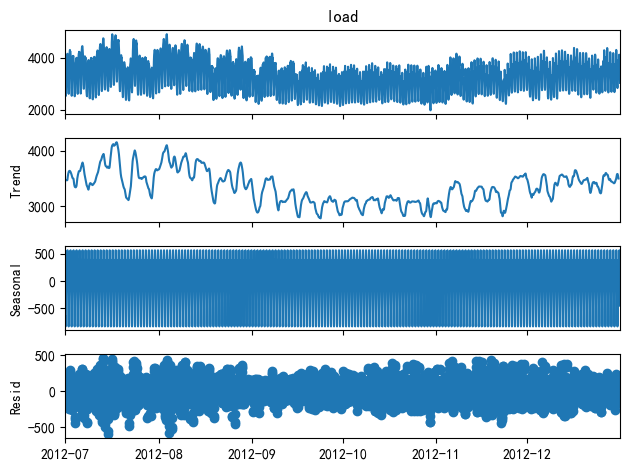

In [11]:
ts_data_load = ts_data["load"]
decomposition = sm.tsa.seasonal_decompose(
    ts_data_load["2012-07-01":"2012-12-31"], model="additive"
) # 分解为趋势周期 (trend-cycle) 、季节性变动 (seasonal variation) 和随机波动 (random fluctuations)三个分量

fig = decomposition.plot()
matplotlib.rcParams["figure.figsize"] = [10.0, 6.0]

对于下图，每年将从1月开始，将月份设置为显示每三个月的变化的小定位器。

Text(0.5, 1.0, '时间序列负荷值及趋势分解图')

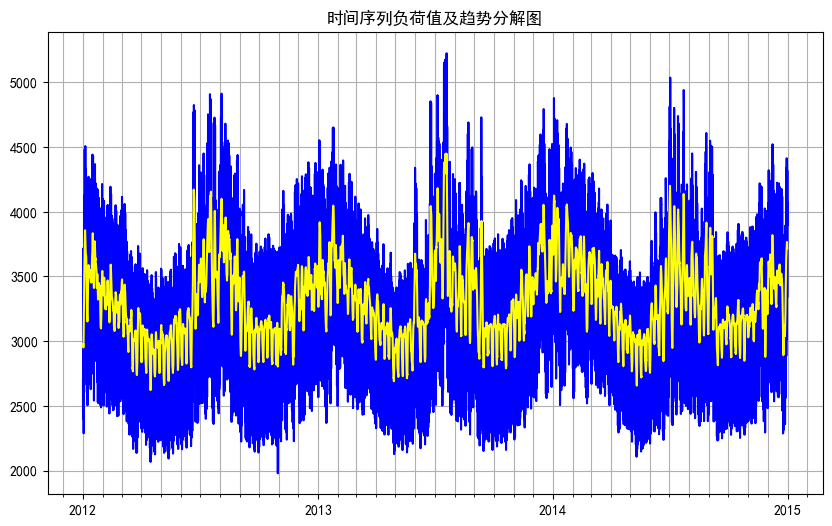

In [12]:
decomposition = sm.tsa.seasonal_decompose(ts_data_load, model="additive")

fig, ax = plt.subplots()
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)

year_format = mdates.DateFormatter("%Y")
month_format = mdates.DateFormatter("%m")

ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which="minor")
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot(ts_data_load.index, ts_data_load, c="blue")
plt.plot(decomposition.trend.index, decomposition.trend, c="yellow")
plt.title("时间序列负荷值及趋势分解图")

## 时间序列中缺失值的数据清理

时间序列中常用**线性插值**来填充缺失值，df.interpolate()函数可以填充，但仅支持method='linear'。

In [13]:
ts_data_load.interpolate(limit=8, method='linear', limit_direction='both') 
#limit代表连续出现8个以上缺失值，就不会填充。limit_direction='both'：插值的极限方向

2012-01-01 00:00:00   2,698.00
2012-01-01 01:00:00   2,558.00
2012-01-01 02:00:00   2,444.00
2012-01-01 03:00:00   2,402.00
2012-01-01 04:00:00   2,403.00
                        ...   
2014-12-31 19:00:00   4,012.00
2014-12-31 20:00:00   3,856.00
2014-12-31 21:00:00   3,671.00
2014-12-31 22:00:00   3,499.00
2014-12-31 23:00:00   3,345.00
Name: load, Length: 26304, dtype: float64

In [14]:
temp_mode = stats.mode(ts_data["temp"]).mode #返回出现最多的值
ts_data["temp"] = ts_data["temp"].fillna(temp_mode)
ts_data.isnull().sum()

load    0
temp    0
dtype: int64

## 归一化和标准化时间序列数据

### 归一化

归一化将所有值都约束在0到1的范围内。对于使用**距离估计、线性回归以及处理输入值校准的神经网络算法**，必须进行归一化。

In [15]:
values = ts_data_load.values
values = values.reshape((len(values), 1))

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print("Min: %f, Max: %f" % (scaler.data_min_, scaler.data_max_))

Min: 1979.000000, Max: 5224.000000


对归一化后的数据进行反转以再次显示原始值。

In [16]:
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])

inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])

[0.22]
[0.18]
[0.14]
[0.13]
[0.13]
[2698.]
[2558.]
[2444.]
[2402.]
[2403.]


### 标准化

标准化使观测值的均值为0，标准差为1。标准化假设观测结果符合高斯分布，且均值和标准差表现良好。这包括**支持向量机、线性和逻辑回归等，以及采用已改善高斯数据性能的其他算法**。

In [17]:
values = ts_data_load.values
values = values.reshape((len(values), 1))

scaler = StandardScaler()
scaler = scaler.fit(values)
print("Mean: %f, StandardDeviation: %f" % (scaler.mean_, sqrt(scaler.var_)))

Mean: 3303.769199, StandardDeviation: 564.568521


In [18]:
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])

inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])

[-1.07]
[-1.32]
[-1.52]
[-1.6]
[-1.6]
[2698.]
[2558.]
[2444.]
[2402.]
[2403.]


## 时间序列特征工程

### 日期时间特征

日期时间特征是根据每个观测的时间戳创建的特征，这些特征的几个示例是每个观测的整数小时、月、一周的每一天。

In [19]:
ts_data["hour"] = [ts_data.index[i].hour for i in range(len(ts_data))]
ts_data["month"] = [ts_data.index[i].month for i in range(len(ts_data))]
ts_data["dayofweek"] = [ts_data.index[i].day for i in range(len(ts_data))]
print(ts_data.head(5))

                        load  temp  hour  month  dayofweek
2012-01-01 00:00:00 2,698.00 32.00     0      1          1
2012-01-01 01:00:00 2,558.00 32.67     1      1          1
2012-01-01 02:00:00 2,444.00 30.00     2      1          1
2012-01-01 03:00:00 2,402.00 31.00     3      1          1
2012-01-01 04:00:00 2,403.00 32.00     4      1          1


以下是一些可以构建并生成其他重要信息的特征示例：
- 是否是周末
- 一天中的分钟
- 是否是夏时制
- 是否有公共假期
- 一年中的季度
- 一天中的小时
- 营业时间之前或之后
- 一年中的季节

日期时间特征不仅限于整数值，还可以是二进制特征。

### 滞后特征和窗口特征

#### shift

frame.shift(periods=1, freq=None, axis=0) periods类型为int，表示移动的幅度，可以是正数，也可以是负数，默认值为1，1表示移动一次，这里移动的是数据，而索引是不移动的，移动之后没有对应值的，为NaN。以下为freq的参数设置。

![hello](../images/p8.jpg)
![hello](../images/p9.jpg)

In [20]:
ts_data.head(5)

,load,temp,hour,month,dayofweek
2012-01-01 00:00:00,"2,698.00",32.00,0,1,1
2012-01-01 01:00:00,"2,558.00",32.67,1,1,1
2012-01-01 02:00:00,"2,444.00",30.00,2,1,1
2012-01-01 03:00:00,"2,402.00",31.00,3,1,1
2012-01-01 04:00:00,"2,403.00",32.00,4,1,1


In [21]:
ts_data_shift = ts_data.shift(4, freq='1H') #滞后4小时
ts_data_shift.head(5)

,load,temp,hour,month,dayofweek
2012-01-01 04:00:00,"2,698.00",32.00,0,1,1
2012-01-01 05:00:00,"2,558.00",32.67,1,1,1
2012-01-01 06:00:00,"2,444.00",30.00,2,1,1
2012-01-01 07:00:00,"2,402.00",31.00,3,1,1
2012-01-01 08:00:00,"2,403.00",32.00,4,1,1


In [21]:
#滞后函数，每后移一位创建一个特征，max_lag表示最多后移几位
def generated_lagged_features(ts_data, var, max_lag):
    for t in range(1, max_lag + 1):
        ts_data[var + "_lag" + str(t)] = ts_data[var].shift(t, freq="1H")

In [22]:
generated_lagged_features(ts_data, "load", 8)
generated_lagged_features(ts_data, "temp", 8)
print(ts_data.head(5))

                       load   temp  hour  month  dayofweek  load_lag1  \
2012-01-01 00:00:00  2698.0  32.00     0      1          1        NaN   
2012-01-01 01:00:00  2558.0  32.67     1      1          1     2698.0   
2012-01-01 02:00:00  2444.0  30.00     2      1          1     2558.0   
2012-01-01 03:00:00  2402.0  31.00     3      1          1     2444.0   
2012-01-01 04:00:00  2403.0  32.00     4      1          1     2402.0   

                     load_lag2  load_lag3  load_lag4  load_lag5  ...  \
2012-01-01 00:00:00        NaN        NaN        NaN        NaN  ...   
2012-01-01 01:00:00        NaN        NaN        NaN        NaN  ...   
2012-01-01 02:00:00     2698.0        NaN        NaN        NaN  ...   
2012-01-01 03:00:00     2558.0     2698.0        NaN        NaN  ...   
2012-01-01 04:00:00     2444.0     2558.0     2698.0        NaN  ...   

                     load_lag7  load_lag8  temp_lag1  temp_lag2  temp_lag3  \
2012-01-01 00:00:00        NaN        NaN        N

添加滞后特征的操作被称为**滑动窗口法**或窗口特征。

一个常见的问题是，窗口的大小应该多大。一个好的方法是构建一系列不同的窗口宽度，或者从数据集中添加和删除他们，以查看哪个宽度对你的模型性能有更积极地影响。

### 滚动窗口统计信息

#### rolling

滚动窗口统计信息的关键步骤是定义观测值的滚动窗口：首先在滚动窗口中获取每个时间点的观测值，并使用它们来计算决定使用的统计信息。接下来，需要进入下一个时间点，并对下一个窗口的观测值重复相同的计算。

**移动平均**：移动一个时间窗口(当前点的前n个)，并计算该时间段的均值。pandas使用rolling()函数。

![hellworld](../images/rolling.png)

In [23]:
shifted = ts_data_load.shift(1) #每次移动一个点

window = shifted.rolling(window=2)
means = window.mean() #滑动平均
new_dataframe = pd.concat([means, ts_data_load], axis=1)
new_dataframe.columns = ["load_rol_mean", "load"]

print(new_dataframe.head(10))

                     load_rol_mean    load
2012-01-01 00:00:00            NaN  2698.0
2012-01-01 01:00:00            NaN  2558.0
2012-01-01 02:00:00         2628.0  2444.0
2012-01-01 03:00:00         2501.0  2402.0
2012-01-01 04:00:00         2423.0  2403.0
2012-01-01 05:00:00         2402.5  2453.0
2012-01-01 06:00:00         2428.0  2560.0
2012-01-01 07:00:00         2506.5  2719.0
2012-01-01 08:00:00         2639.5  2916.0
2012-01-01 09:00:00         2817.5  3105.0


In [24]:
width = 4
shifted = ts_data_load.shift(width - 1) #每次移动3个点
window = shifted.rolling(window=width)

new_dataframe = pd.concat([window.min(), window.mean(), window.max(), ts_data_load], axis=1)
new_dataframe.columns = ["min", "mean", "max", "load"]

print(new_dataframe.head(10))

                        min     mean     max    load
2012-01-01 00:00:00     NaN      NaN     NaN  2698.0
2012-01-01 01:00:00     NaN      NaN     NaN  2558.0
2012-01-01 02:00:00     NaN      NaN     NaN  2444.0
2012-01-01 03:00:00     NaN      NaN     NaN  2402.0
2012-01-01 04:00:00     NaN      NaN     NaN  2403.0
2012-01-01 05:00:00     NaN      NaN     NaN  2453.0
2012-01-01 06:00:00  2402.0  2525.50  2698.0  2560.0
2012-01-01 07:00:00  2402.0  2451.75  2558.0  2719.0
2012-01-01 08:00:00  2402.0  2425.50  2453.0  2916.0
2012-01-01 09:00:00  2402.0  2454.50  2560.0  3105.0


### 扩展窗口统计信息

#### expanding

扩展窗口是包含所有历史数据的特征。pandas使用expanding()函数，该函数为每个时间步提供扩展的转换和所有先验值的集合。与rolling()函数功能相同。

![hellworld](../images/expanding.png)

In [25]:
window = ts_data_load.expanding(3)
new_dataframe = pd.concat(
    [window.min(), window.mean(), window.max(), ts_data_load.shift(1)], axis=1
)
new_dataframe.columns = ["min", "mean", "max", "load+1"]
print(new_dataframe.head(10))

                        min         mean     max  load+1
2012-01-01 00:00:00     NaN          NaN     NaN     NaN
2012-01-01 01:00:00     NaN          NaN     NaN  2698.0
2012-01-01 02:00:00  2444.0  2566.666667  2698.0  2558.0
2012-01-01 03:00:00  2402.0  2525.500000  2698.0  2444.0
2012-01-01 04:00:00  2402.0  2501.000000  2698.0  2402.0
2012-01-01 05:00:00  2402.0  2493.000000  2698.0  2403.0
2012-01-01 06:00:00  2402.0  2502.571429  2698.0  2453.0
2012-01-01 07:00:00  2402.0  2529.625000  2719.0  2560.0
2012-01-01 08:00:00  2402.0  2572.555556  2916.0  2719.0
2012-01-01 09:00:00  2402.0  2625.800000  3105.0  2916.0


#### ewm

指数加权函数滑动窗口(ewm)算子可以计算指数加权平均值的计算，具体的说来，就是更近观测的数值具有更高的权重，对于ewm指定权重的方式即指定跨度（span），由于给近期的观测值更高的权重，与等权重相比，它对变化适应的更快。

![hellworld](../images/ewm.png)
![hellworld](../images/ewm2.png)

In [27]:
window = ts_data_load.ewm(3)
new_dataframe = pd.concat(
    [window.std(), window.mean(), window.var(), ts_data_load.shift(1)], axis=1
)
new_dataframe.columns = ["std", "mean", "var", "load+1"]
print(new_dataframe.head(10))

                            std         mean           var  load+1
2012-01-01 00:00:00         NaN  2698.000000           NaN     NaN
2012-01-01 01:00:00   98.994949  2618.000000   9800.000000  2698.0
2012-01-01 02:00:00  125.123075  2542.756757  15655.783784  2558.0
2012-01-01 03:00:00  123.392479  2491.280000  15225.703784  2444.0
2012-01-01 04:00:00  109.053535  2462.343150  11892.673393  2402.0
2012-01-01 05:00:00   89.541414  2459.501634   8017.664863  2403.0
2012-01-01 06:00:00   90.160790  2488.496584   8128.968043  2453.0
2012-01-01 07:00:00  136.745280  2552.533345  18699.271622  2560.0
2012-01-01 08:00:00  211.539588  2650.776570  44748.997295  2719.0
2012-01-01 09:00:00  283.688301  2771.108756  80479.052187  2916.0


# 传统时间序列预测方法

经典的时间序列预测方法一般侧重于历史数据和未来结果之间的线性关系。

## 平稳性检验

### 图形分析方法

- 可视化数据即绘制时间序列的折线图，看曲线是否围绕某一数值上下波动（判断均值是否稳定），看曲线上下波动幅度变化大不大（判断方差是否稳定），看曲线不同时间段波动的频率变化大不大（判断协方差是否稳定），以此来判断时间序列是否是平稳的。

- 可视化统计特征，是指绘制时间序列的自相关图和偏自相关图，根据自相关图的表现来判断序列是否平稳。

Text(0.5, 1.0, '时间序列负荷值及趋势分解图')

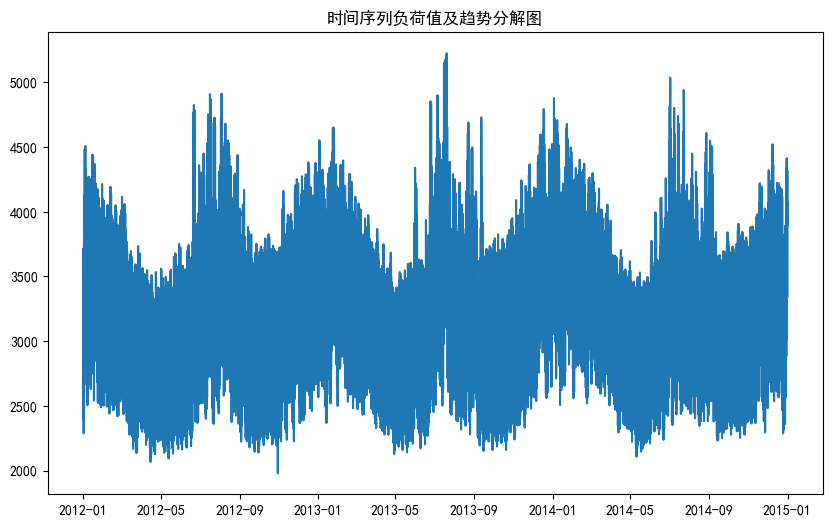

In [16]:
ts_data_load = ts_data["load"]
plt.plot(ts_data_load.index, ts_data_load)
plt.title("时间序列负荷值及趋势分解图")

曲线上下波动，波动幅度前后、上下一致，为平稳序列。

### 简单统计方法

In [17]:
#将数据拆分为2份，计算每份的均值，方差
def describe(X):
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f\n' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

In [18]:
describe(ts_data_load)

mean1=3259.103748, mean2=3348.434649

variance1=307931.570427, variance2=325601.825305


序列均值和方差略有不同，但大致在同一水平线上，所以为平稳时间序列。

### 假设检验方法

#### 差分

为什么先差分再检验平稳性？

- 大部分经典时间序列模型，如ARIMA模型，要求时间序列是平稳的。只有当时间序列平稳时，才能有效运用这些模型来进行预测和建模。

- 差分操作可以去除时间序列中的趋势、季节性等非平稳性因素，使得原始数据更符合平稳性的要求。

- 差分操作可以消除时间序列的自相关性，使得之后的模型拟合和预测更加准确可靠。

In [19]:
# data为时间序列数据，n为差分次数，默认为1
def difference(data, n=1):
    diff = data.diff(n)
    diff.dropna(inplace=True)
    return diff

# 差分1次
diff_data = difference(ts_data_load)
diff_data.shape

(26303,)

#### ADF单位根检验

ADF单位根检验：检验结果包括ADF统计量、p值以及临界值。若 p 值小于显著性水平（常见使用的是0.05），则可以拒绝原假设，即数据是平稳的，反之。

In [20]:
from statsmodels.tsa.stattools import adfuller

# data为时间序列数据
result = adfuller(diff_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[1]<0.05:
    print("该序列是平稳的")
else:
    print("该序列是非平稳的")

ADF Statistic: -25.763207
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
该序列是平稳的


#### KPSS检验

KPSS检验：检验结果包括KPSS统计量、p值以及临界值。若 p 值小于显著性水平，则可以拒绝原假设，即数据是非平稳的，反之。

In [22]:
from statsmodels.tsa.stattools import kpss

# data为时间序列数据
result = kpss(diff_data)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))
    
if result[1]>0.05:
    print("该序列是平稳的")
else:
    print("该序列是非平稳的")

KPSS Statistic: 0.007016
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
该序列是平稳的


## 自回归

自回归(**AR(p)**)是一种时间序列预测方法，仅依赖于时间序列的先前输出：该技术假设下一个时间戳的未来观测值与先前时间戳的观测值存在线性关系。

在自回归中，前一个时间戳的输出值成为预测下一个时间戳的输入值，并且误差遵循简单线性回归模型中关于误差的一般假设。

在自回归中，时间序列中用于预测下一个时间戳的先前输入值的数量成为顺序（用p表示），该顺序值决定了使用多少个先前的数据点。通常使用最小的赤池信息量准则（AIC）得出的模型来估计p值。

将当前预测值基于紧接在前的值的自回归称为**一阶自回归**。

如果使用前两个值来预测下一个时间戳的值，该方法称为**二阶自回归**。

更一般地，n阶自回归是**多重线性回归**。

![hello](../images/p10.jpg)
![hello](../images/p11.jpg)

### 自相关

**自相关**是自回归的一个关键概念，当时间序列与其自身的之前或滞后版本线性相关时，就会出现。

自相关对于识别时间序列数据中的季节性和趋势非常有用。


### 滞后图

pandas提供**滞后图**（lag_plot）的方法用于检查时间序列数据是否存在自相关。

In [82]:
ts_data_load.head()

2012-01-01 00:00:00   2,698.00
2012-01-01 01:00:00   2,558.00
2012-01-01 02:00:00   2,444.00
2012-01-01 03:00:00   2,402.00
2012-01-01 04:00:00   2,403.00
Freq: H, Name: load, dtype: float64

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

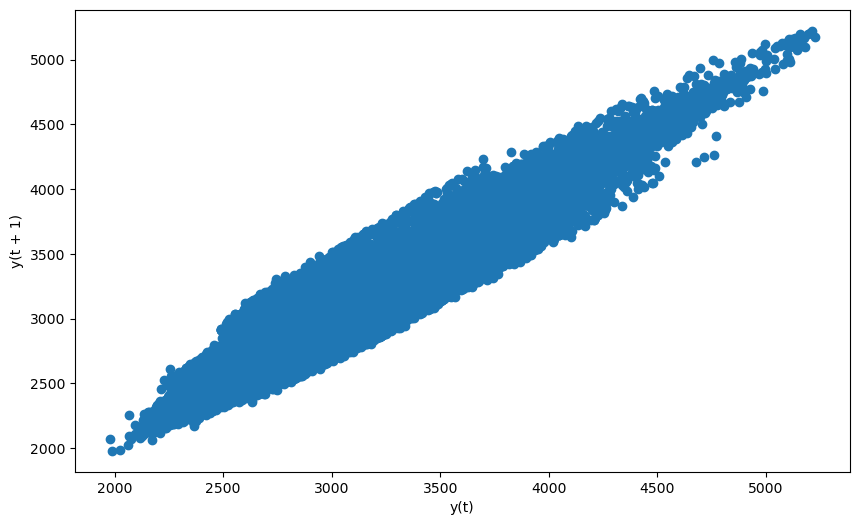

In [81]:
from pandas.plotting import lag_plot
plt.figure()
lag_plot(ts_data_load)

### 自相关图

如果时间序列是随机的，则所有时间滞后的自相关值应该接近于零，如果不是随机的，那么一个或多个自相关将显著非零。

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

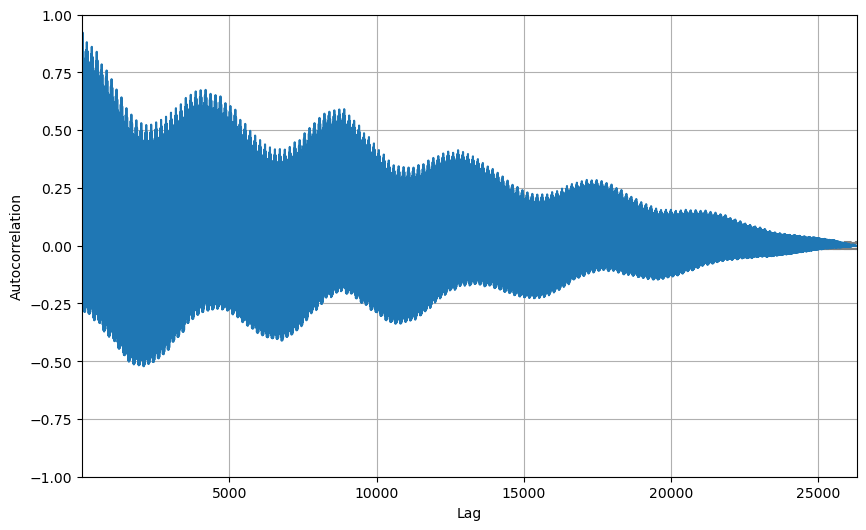

In [83]:
from pandas.plotting import autocorrelation_plot
plt.figure()
autocorrelation_plot(ts_data_load)

如下图所示：自相关图显示了垂直轴上的自相关函数值，它的范围是-1到1.图中虚线代表99%置信区间，实线是95%置信区间。自相关图旨在揭示时间序列的数据点是正相关的、负相关的还是不相关的。

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

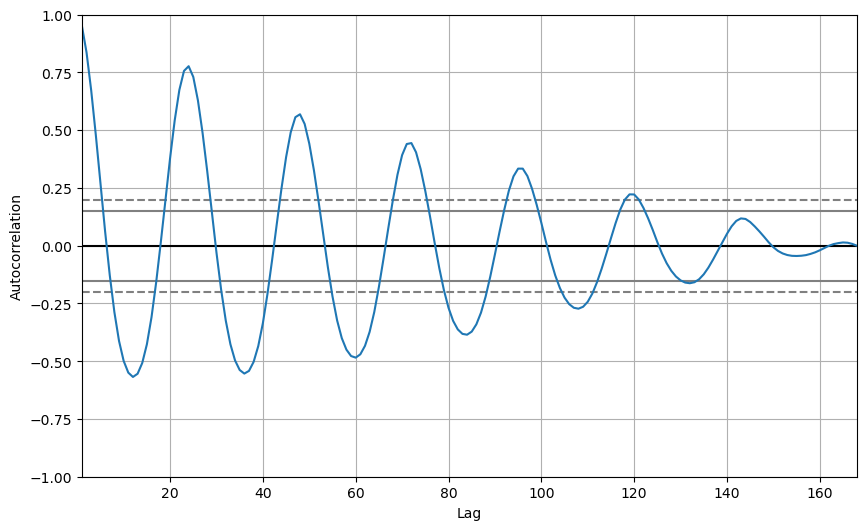

In [84]:
ts_data_load_subset = ts_data_load["2014-08-01":"2014-08-07"]
from pandas.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(ts_data_load_subset)

### 自相关函数

时间序列的滞后自相关图也称为自相关函数（ACF）。下图横轴代表滞后数，纵轴代表自相关值。

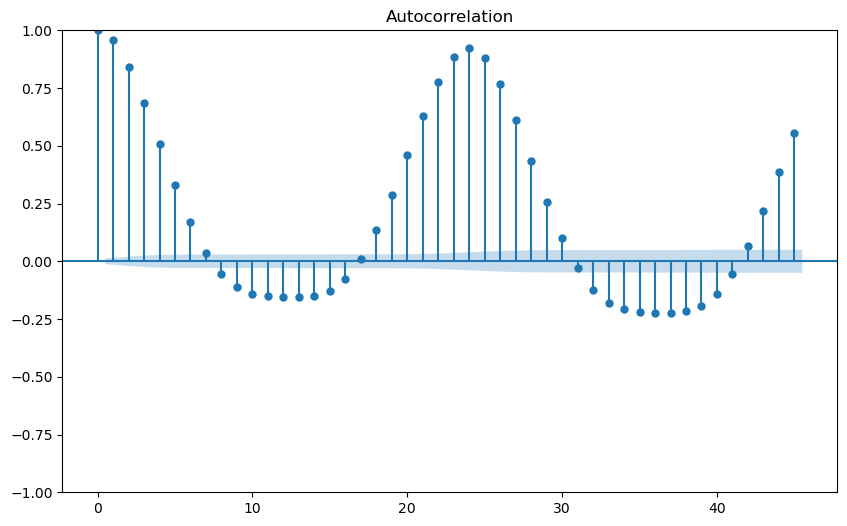

In [85]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_data_load)
pyplot.show()

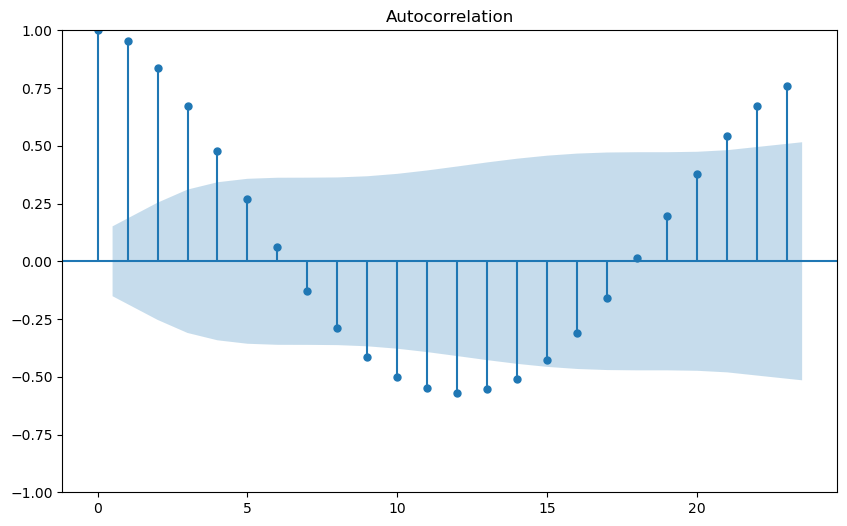

In [86]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_data_load_subset)
pyplot.show()

上面两个图中，置信区间被绘制成圆锥形，默认置信区间设置为95%，这表明该圆锥体之外的值很可能是相关的。

自相关系数很快就衰减到0附近，是明显的平稳序列。滞后期为0时自相关系数和偏自相关系数其实就是序列自己和自己的相关性，故为1。

### 部分相关函数

部分相关函数（PACF）是一种条件相关，假设我们考虑一些其他变量集的值，这就是两个变量之间的相关性。PACF不是像ACF一样找到当前值与滞后的相关性，而是找到残差与下一个滞后的相关性。

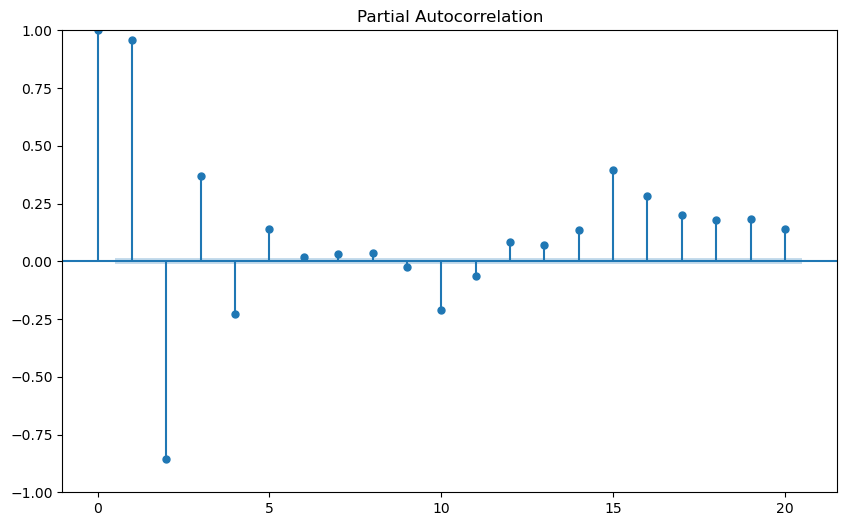

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts_data_load, lags=20) #前20个滞后量
pyplot.show()

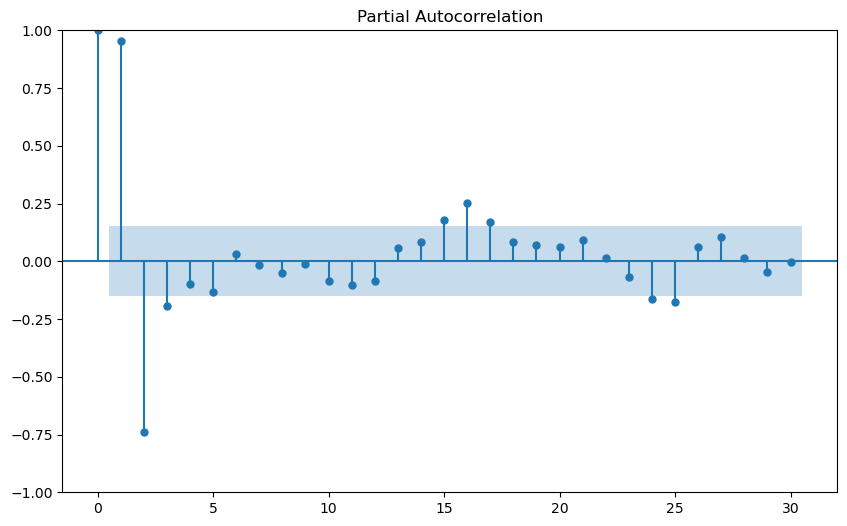

In [88]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts_data_load_subset, lags=30) #前30个滞后量
pyplot.show()

在上图中我们可以看到在图第一次切割上置信区间之前，最多1个滞后具有良好的相关性，这是p值，是自回归过程的顺序。

**当需要确定自回归和移动平均时间序列方法的顺序（p）时，ACF和PACF图尤为重要，可以用两种方法确定自回归模型的顺序：**
- ACF和PACF函数
- AIC和BIC信息准则

### 信息量准则

模型中包含的滞后变量越多，模型对数据的拟合就越好，这也代表模型有过拟合的风险。信息量准则通过使用参数数量施加惩罚来调整模型的拟合优度。有两种拟合优度指标：
- 赤池信息量准则（AIC）
- 贝叶斯信息量准则（BIC）

信息量准则用于拟合多个模型，每个模型具有不同数量的参数，并选择具有最低贝叶斯信息量准则的模型。

### python自回归模型

python支持statsmodels库中的AutoReg模型进行自回归建模。

In [152]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [153]:
model = AutoReg(ts_data_load, 1) #1表示滞后量是1
results = model.fit()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Mon, 27 Nov 2023   AIC                         343285.956
Time:                        20:25:04   BIC                         343310.488
Sample:                    01-01-2012   HQIC                        343293.877
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.5181      6.043     23.913      0.000     132.673     156.363
load.L1        0.9563      0.002    530.344      0.000       0.953       0.960
                                    Roots           

In [155]:
res = model.fit(cov_type="HC0") #White检验
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Mon, 27 Nov 2023   AIC                         343285.956
Time:                        20:25:08   BIC                         343310.488
Sample:                    01-01-2012   HQIC                        343293.877
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.5181      5.364     26.945      0.000     134.006     155.030
load.L1        0.9563      0.002    618.131      0.000       0.953       0.959
                                    Roots           

In [156]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
sns.mpl.rc("figure", figsize=(16, 6))

通过使用plot_predict，可以对预测可视化。

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


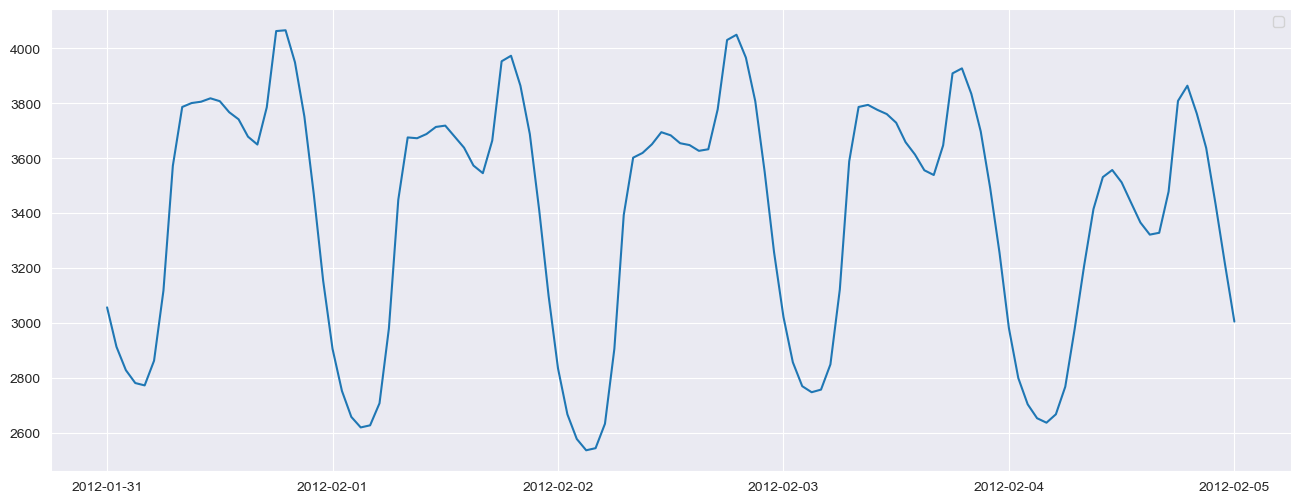

In [157]:
fig = res.plot_predict(720, 840)

plot_diagnostics表示模型捕获了数据中的关键特征。

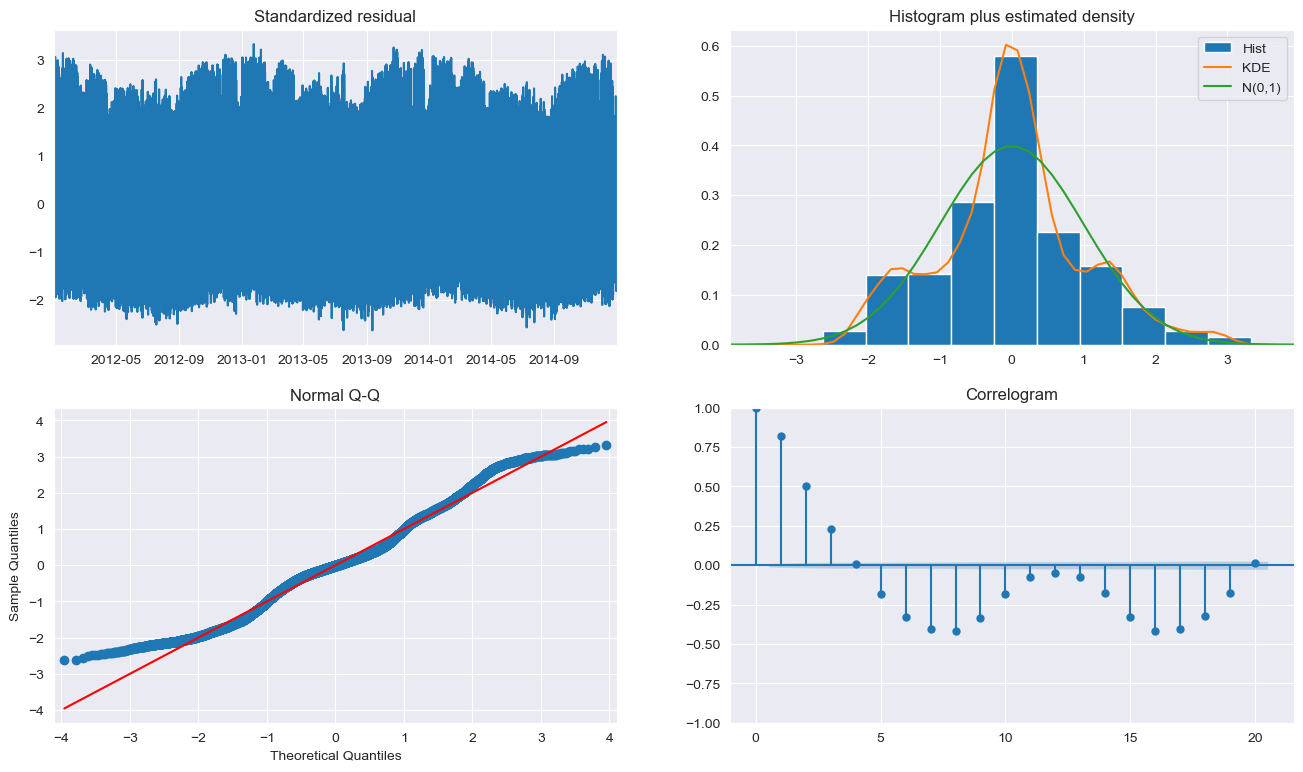

In [148]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=20)

最后，我们测试`AutoReg`函数的预测能力，使用`predict`函数生成预测，默认是单步预测，生成多步预测需要`dynamic=True`。

### 完整流程

定义训练集和测试集开始的时间。

In [32]:
train_start_dt = "2014-11-01 00:00:00"
test_start_dt = "2014-12-30 00:00:00"

过滤原始数据集。

In [33]:
ts_data_load = pd.DataFrame(ts_data["load"], columns=['load'])
train = ts_data_load.copy()[(ts_data_load.index >= train_start_dt)
                            & (ts_data_load.index < test_start_dt)][["load"]]
test = ts_data_load.copy()[ts_data_load.index >= test_start_dt][["load"]]

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [34]:
train

,load
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"
...,...
2014-12-29 19:00:00,"4,183.00"
2014-12-29 20:00:00,"4,033.00"
2014-12-29 21:00:00,"3,778.00"
2014-12-29 22:00:00,"3,459.00"


归一化。

In [35]:
scaler = MinMaxScaler()
# train['load'] = scaler.fit_transform(train)
scaler = scaler.fit(ts_data_load)
train['load'] = scaler.transform(train)
train.head()

,load
2014-11-01 00:00:00,0.16
2014-11-01 01:00:00,0.14
2014-11-01 02:00:00,0.13
2014-11-01 03:00:00,0.12
2014-11-01 04:00:00,0.14


In [36]:
test["load"] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.32
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.28
2014-12-30 03:00:00,0.28
2014-12-30 04:00:00,0.30


In [37]:
#指定提前预测的步骤数
HORIZON = 3
print("Forecasting horizon:", HORIZON, "hours")

Forecasting horizon: 3 hours


In [38]:
#创建测试数据点
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted["load+" + str(t)] = test_shifted["load"].shift(-t, freq="H")

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load,load+1,load+2
2014-12-30 00:00:00,0.32,0.29,0.28
2014-12-30 01:00:00,0.29,0.28,0.28
2014-12-30 02:00:00,0.28,0.28,0.30
2014-12-30 03:00:00,0.28,0.30,0.38
2014-12-30 04:00:00,0.30,0.38,0.49


In [39]:
#预测
training_window = 720

train_ts = train["load"]
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    history.pop(0) 
    print(test_ts.index[t])
    print(t + 1, ": predicted =", yhat, "expected =", obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.29] expected = [0.32172573189522335, 0.29460708782742684, 0.2835130970724191]
2014-12-30 01:00:00
2 : predicted = [0.3 0.3 0.3] expected = [0.29460708782742684, 0.2835130970724191, 0.27950693374422186]
2014-12-30 02:00:00
3 : predicted = [0.28 0.29 0.32] expected = [0.2835130970724191, 0.27950693374422186, 0.30323574730354386]
2014-12-30 03:00:00
4 : predicted = [0.29 0.32 0.38] expected = [0.27950693374422186, 0.30323574730354386, 0.3759630200308166]
2014-12-30 04:00:00
5 : predicted = [0.3  0.36 0.47] expected = [0.30323574730354386, 0.3759630200308166, 0.4865947611710324]
2014-12-30 05:00:00
6 : predicted = [0.37 0.48 0.55] expected = [0.3759630200308166, 0.4865947611710324, 0.5630200308166409]
2014-12-30 06:00:00
7 : predicted = [0.49 0.56 0.61] expected = [0.4865947611710324, 0.5630200308166409, 0.598151001540832]
2014-12-30 07:00:00
8 : predicted = [0.56 0.61 0.64] expected = [0.5630200308166409, 0.598151001540832, 0.61201848998459

## 移动平均

移动平均(**MA(q)**)技术利用回归方法中的先前预测误差来预测下一个时间戳的未来观测值：每个未来观测值可以被认为是先前预测误差的加权移动平均。只适用于近期预测，且数据发展趋势不大。

**自回归模型代表过去观测值的线性组合，而移动平均模型代表过去误差项的组合。**

In [142]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_data_load, order=(0, 0, 1)) #q=1，代表选择MA模型
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                26304
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -186910.844
Date:                Mon, 27 Nov 2023   AIC                         373827.688
Time:                        20:18:57   BIC                         373852.221
Sample:                    01-01-2012   HQIC                        373835.609
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3303.7674      3.569    925.642      0.000    3296.772    3310.763
ma.L1          0.9616      0.002    549.644      0.000       0.958       0.965
sigma2      8.699e+04    874.328     99.498      0.0

## 自回归移动平均

自回归移动平均(**ARMA(p,q)**)由两部分组成：
- 自回归
- 移动平均

ARMA模型用于根据两个多项式来描述每周平稳随机时间序列。第一个p多项式用于自回归，第二个q用于移动平均。

In [160]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_data_load, order=(1, 0, 1)) #p=1,q=1，代表选择ARMA模型
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                26304
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -159105.472
Date:                Mon, 27 Nov 2023   AIC                         318218.944
Time:                        20:41:01   BIC                         318251.654
Sample:                    01-01-2012   HQIC                        318229.506
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3303.7690     21.236    155.577      0.000    3262.148    3345.390
ar.L1          0.9434      0.002    392.705      0.000       0.939       0.948
ma.L1          0.8528      0.003    257.066      0.0

## 差分自回归移动平均

差分自回归移动平均(**ARIMA(p,d,q)**)模型是ARMA模型的发展。增加了差分技术（例如，从时间t-1观测到的值减去时间t观测到的值）使时间序列平稳。估计时间序列平稳性需要多少非季节性差异的过程被称为积分法。

ARIMA模型有三个主要组成部分，分别表示为p，d，q；这些参数的定义入下：
- p代表ARIMA模型中包含的滞后变量的数量，也称为滞后顺序。
- d代表时间序列数据集中原始值的差异次数，也称差异程度。
- q代表移动平均窗口的大小，也称为移动顺序平均。

### ARIMA参数详解

In [161]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA一般形式为ARIMA(p,d,q)，其中p代表自回归的顺序，d代表差分阶数，q代表移动平均多项式的顺序。存在参数`order=(p,d,q)`：
- 如果`order=(p,0,0)`，则代表选择移动平均模型（MA）
- 如果`order=(0,0,q)`，则代表选择自回归模型（AR）
- 如果`order=(p,0,q)`，则代表选择自回归移动平均模型（ARMA）
- 如果`order=(p,d,q)`，则代表选择自回归差分移动平均模型（ARIMA）。

In [162]:
model = ARIMA(ts_data_load, order=(1, 1, 1)) #p=1,d=1,q=1，代表选择ARIMA模型
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                26304
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -153477.857
Date:                Mon, 27 Nov 2023   AIC                         306961.714
Time:                        20:55:24   BIC                         306986.246
Sample:                    01-01-2012   HQIC                        306969.635
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6773      0.004    164.823      0.000       0.669       0.685
ma.L1          0.6112      0.006    102.521      0.000       0.600       0.623
sigma2      6849.5180     43.255    158.352      0.0

### SARIMAX参数详解

SARIMAX代表具有外源因素的季节性差分自回归移动平均模型。它不仅需要ARIMA所要求的p,d和q参数，还需要季节性方面的另一组p,d,q和s参数，s是时间序列数据集中季节性周期的周期性。

![hello](../images/p12.jpg)
![hello](../images/p13.jpg)

### 完整流程

In [40]:
train_start_dt = "2014-11-01 00:00:00"
test_start_dt = "2014-12-30 00:00:00"

In [41]:
train = ts_data_load.copy()[
    (ts_data_load.index >= train_start_dt) & (ts_data_load.index < test_start_dt)
][["load"]]
test = ts_data_load.copy()[ts_data_load.index >= test_start_dt][["load"]]

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [42]:
scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)
train.head()

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06


In [43]:
test["load"] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [170]:
HORIZON = 3 #提前预测3小时
print("Forecasting horizon:", HORIZON, "hours")

Forecasting horizon: 3 hours


In [171]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24) #季节性顺序

In [172]:
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.209
Date:                            Mon, 27 Nov 2023   AIC                          -6942.418
Time:                                    21:15:18   BIC                          -6910.991
Sample:                                11-01-2014   HQIC                         -6930.666
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8400      0.016     52.491      0.000       0.809       0.871
ar.L2         -0.5183      0.034   

**向前传播**是时间序列模型评估的黄金标准。从时间序列开始，我们在训练集上训练模型，然后对下一个时间步进行预测，再根据已知值对预测进行评估。在实践中，每次有新数据可用时，时间序列模型都会重新训练。

In [44]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted["load+" + str(t)] = test_shifted["load"].shift(-t, freq="H")

test_shifted = test_shifted.dropna(how="any")
test_shifted.head(5)

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


In [174]:
training_window = 720

train_ts = train["load"]
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):] #向前传播，每次取720个值

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    history.pop(0) #每次向训练集添加新的观测值时，都会从训练集的开头删除观测值
    print(test_ts.index[t])
    print(t + 1, ": predicted =", yhat, "expected =", obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

In [175]:
#预测值与实际值比较
eval_df = pd.DataFrame(predictions,
                       columns=["t+" + str(t) for t in range(1, HORIZON + 1)])
eval_df["timestamp"] = test.index[0:len(test.index) - HORIZON + 1]
eval_df = pd.melt(eval_df,
                  id_vars="timestamp",
                  value_name="prediction",
                  var_name="h")
eval_df["actual"] = np.array(np.transpose(test_ts)).ravel()
eval_df[["prediction", "actual"
         ]] = scaler.inverse_transform(eval_df[["prediction", "actual"]])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,008.85","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,955.74","2,935.00"
2,2014-12-30 02:00:00,t+1,"2,900.14","2,899.00"
3,2014-12-30 03:00:00,t+1,"2,917.96","2,886.00"
4,2014-12-30 04:00:00,t+1,"2,947.01","2,963.00"


In [178]:
#计算绝对百分比误差APE
if HORIZON > 1:
    eval_df["APE"] = (eval_df["prediction"] - eval_df["actual"]).abs() / eval_df["actual"]
    print(eval_df.groupby("h")["APE"].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [198]:
#计算平均绝对百分比误差
mape = ((eval_df["prediction"] - eval_df["actual"]).abs() / eval_df["actual"]).mean()
print(mape)

0.011459507664559833


## 总结

1、自回归：该时间序列技术假设下一个时间戳的未来观测值与前一个时间戳的观测值呈线性关系。

2、移动平均：该时间序列技术利用回归方法中以前的预测误差来预测下一个时间戳的未来观测值。

3、自回归移动平均：该时间序列技术假设下一个时间戳的未来观测值可以表示为先前时间戳的观测值和残差的线性函数。

4、差分自回归移动平均：该时间序列技术假设下一个时间戳的未来观测值可以表示为先前时间戳的差分观测值和残差的线性函数。
